# Estimating Aqueous Solubility of Chemicals using Machine Learning Techniques


# Summary and Background

Approximately 40% of all drug research projects fail due to low chemical solubility in water. Solubility is a major factor in whether or not drugs will be bioavailable to a human body. 

Solubility is still not fully understood and no equation is perfect in estimating it. There have been attempts to model solubility using metrics like melting point and lipophilicity,  but these metrics are also difficult to model. Melting point, for example, can vary based on the crystalline structure of identical molecules, leading to increased uncertainty In the solubility model.

For this project, we will be reviewing some of the models that are used to predict solubility as well as experiment with some alternative models. 


## Importing Required Libaries

In [1]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.api import OLS

import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

## Data Sources

For this project, we compiled a large dataset containing lists of chemicals and their associated SLN codes. 

- Delaney – ESOL: Estimating Aqueous Solubility Directly from Molecular Structure
- Huuskonen-  Aqueous Solubility Prediction of Drugs Based on Molecular Topology and Neural Network Modeling
- Hewitt - In Silico Prediction of Aqueous Solubility: The Solubility Challenge
- Llinas - Solubility Challenge: Can You Predict Solubilities of 32 Molecules Using a Database of 100 Reliable Measurements?
- Wang - Development of reliable aqueous solubility models and their application in drug-like analysis
- Jain - Estimation of the aqueous solubility I: application to organic nonelectrolytes
- Beilstein - Development of a Water Solubility Dataset to Establish Best Practices for Curating New Datasets for QSAR Modeling


Each dataset has entries relating to the chemical structure of each chemical in either SYBYL notation or SMILES notation. 

A lot of manual cleaning was performed in order for this merge to work properly. Data will be added into the repo for later use.

In [2]:
current_dir = Path(os.getcwd()).absolute()
data_dir = current_dir.joinpath('data')

df = pd.DataFrame()
for _, _, files in os.walk(data_dir):
    for file in files:
        tmp = pd.read_excel(data_dir.joinpath(file), skiprows=2)
        df = pd.concat([df, tmp])

df.dropna(axis = 0, subset = ['Expt.'])
df = df[['SLN','Expt.']]
df.columns = ['SLN','LogS']
df = df.drop_duplicates(subset=['SLN'])
df.reset_index(drop=True, inplace=True)
df.to_csv("cleaned_dataset.csv")
df

,SLN,LogS
0,BrC[2]C[3]=C(CH=CHCH=@2)CH=CHCH=CH@3,-4.3500
1,BrC[2]=C(C(=CHC(=CH@2)C#N)Br)OH,-3.3300
2,BrC[2]=C(CH=C(C(=CH@2)Br)Br)Br,-6.9800
3,BrC[2]=C(CH=C(C(=CH@2)Cl)OP(=S)(OCH3)OCH3)Cl,-6.0900
4,BrC[2]=C(CH=C(CH=CH@2)NHC(=O)N(OCH3)CH3)Cl,-3.9200
...,...,...
3659,C[1]H=C(CH=CHC(=CH@1)C(=O)C[13]=CHCH=C(S@13)S(...,-3.3319
3660,C[1]H=C(CH=CHC(=CH@1)C(=O)C[13]=CHCH=C(S@13)S(...,-2.1669
3661,C[1]H=C(CH=CHC(=CH@1)C(=O)C[13]=CHCH=C(S@13)S(...,-1.4812
3662,C[1]H=C(CH=CHC(=CH@1)C(=O)C[13]=CHCH=C(S@13)S(...,-1.8802


## Converting SLN to SMILES

In order to standardize the data, we will first need to convert the SLN codes into SMILES codes. This can be done using the rdkit library

In [3]:
from rdkit.Chem import AllChem as Chem

df['SMILES'] = [Chem.MolToSmiles(Chem.MolFromSLN(chem)) for chem in df['SLN']]
df = df[['SMILES','LogS']]
df

,SMILES,LogS
0,Brc1cccc2ccccc12,-4.3500
1,N#Cc1cc(Br)c(O)c(Br)c1,-3.3300
2,Brc1cc(Br)c(Br)cc1Br,-6.9800
3,COP(=S)(OC)Oc1cc(Cl)c(Br)cc1Cl,-6.0900
4,CON(C)C(=O)Nc1ccc(Br)c(Cl)c1,-3.9200
...,...,...
3659,NS(=O)(=O)c1ccc(C(=O)c2ccc(CNCc3ccccc3)cc2)s1,-3.3319
3660,CCCCNCc1ccc(C(=O)c2ccc(S(N)(=O)=O)s2)cc1,-2.1669
3661,NS(=O)(=O)c1ccc(C(=O)c2ccc(CN3CCOCC3)cc2)s1,-1.4812
3662,CN1CCN(Cc2ccc(C(=O)c3ccc(S(N)(=O)=O)s3)cc2)CC1,-1.8802


# Example of chemical modelling from the rdkit library
We can explore the structure and topology of each chemical using the rdkit library. Here is a quick example

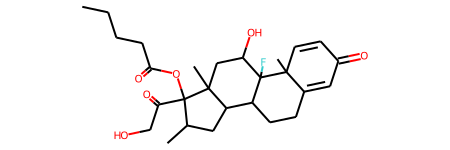

In [4]:
mol = df.iloc[552]['SMILES']
mol = Chem.MolFromSmiles(mol)
mol

# Reproducing the Delaney Model

We will first start by recreating the results of John Delaney’s 2004 paper as a benchmark for our project. In his paper, Delaney states that 9 attributes were originally chosen for the linear regression model, but only four of the attributes had high T values; 

1.	clogP: Octanol water partition coefficient (ratio of the solubility in octanol and water)
2.	Molecular weight (MWT) : Sum of the weights of all atoms in the molecule
3.	Number of rotatable bonds (RB) : Sum of all the single bonds bound to a heavy atom. 
4.	Aromatic proportion (AP): Number of aromatic atoms vs the number of heavy atoms



We can use the SMILES codes we generated to calculator all of these descriptors using the rdkit package. 

In [5]:
# Empty dataframe to add data to
X = pd.DataFrame()

# Creating an intercept for the OLS
X['intercept'] = 1

# Partition Coefficient
X['cLogP'] = [Descriptors.MolLogP(Chem.MolFromSmiles(smile)) for smile in df['SMILES']]

# Molecular Weight
X['Molar Weight'] = [Descriptors.MolWt(Chem.MolFromSmiles(smile)) for smile in df['SMILES']]

# Number of Rotatable Bonds
X['Rotatable Bonds'] = [Descriptors.NumRotatableBonds(Chem.MolFromSmiles(smile)) for smile in df['SMILES']]

In [6]:
def AromaticProportation(smiles):
    """Function to return the aromatic proportions of a chemical"""
    aromatic_atoms = [Chem.MolFromSmiles(smiles).GetAtomWithIdx(i).GetIsAromatic() for i in range(Chem.MolFromSmiles(smiles).GetNumAtoms())]
    heavy_atoms = Descriptors.HeavyAtomCount(Chem.MolFromSmiles(smiles))
    return sum(aromatic_atoms) / heavy_atoms

In [7]:
# Aromatic Proportions
X['Aromatic Proportions'] = df['SMILES'].apply(AromaticProportation)

# Assigning Target
X['target'] = df['LogS']

# Creating an intercept for the OLS
X['intercept'] = 1

# Showing DataFrame
X

,intercept,cLogP,Molar Weight,Rotatable Bonds,Aromatic Proportions,target
0,1,3.60230,207.070,0,0.909091,-4.3500
1,1,2.78888,276.915,0,0.545455,-3.3300
2,1,4.73660,393.698,0,0.600000,-6.9800
3,1,4.65200,366.000,4,0.375000,-6.0900
4,1,3.12760,293.548,2,0.400000,-3.9200
...,...,...,...,...,...,...
3659,1,2.91630,386.498,7,0.653846,-3.3319
3660,1,2.51620,352.481,8,0.478261,-2.1669
3661,1,1.45870,366.464,5,0.458333,-1.4812
3662,1,1.37390,379.507,5,0.440000,-1.8802


## Basic Exploratory Data Analysis

We can use a pair plot from seaborn to see which attributes and combination of attributes best predict solubility. From the pair plot, we can see that cLogP has a very nice correlation with solubility as well as molecular weight. 

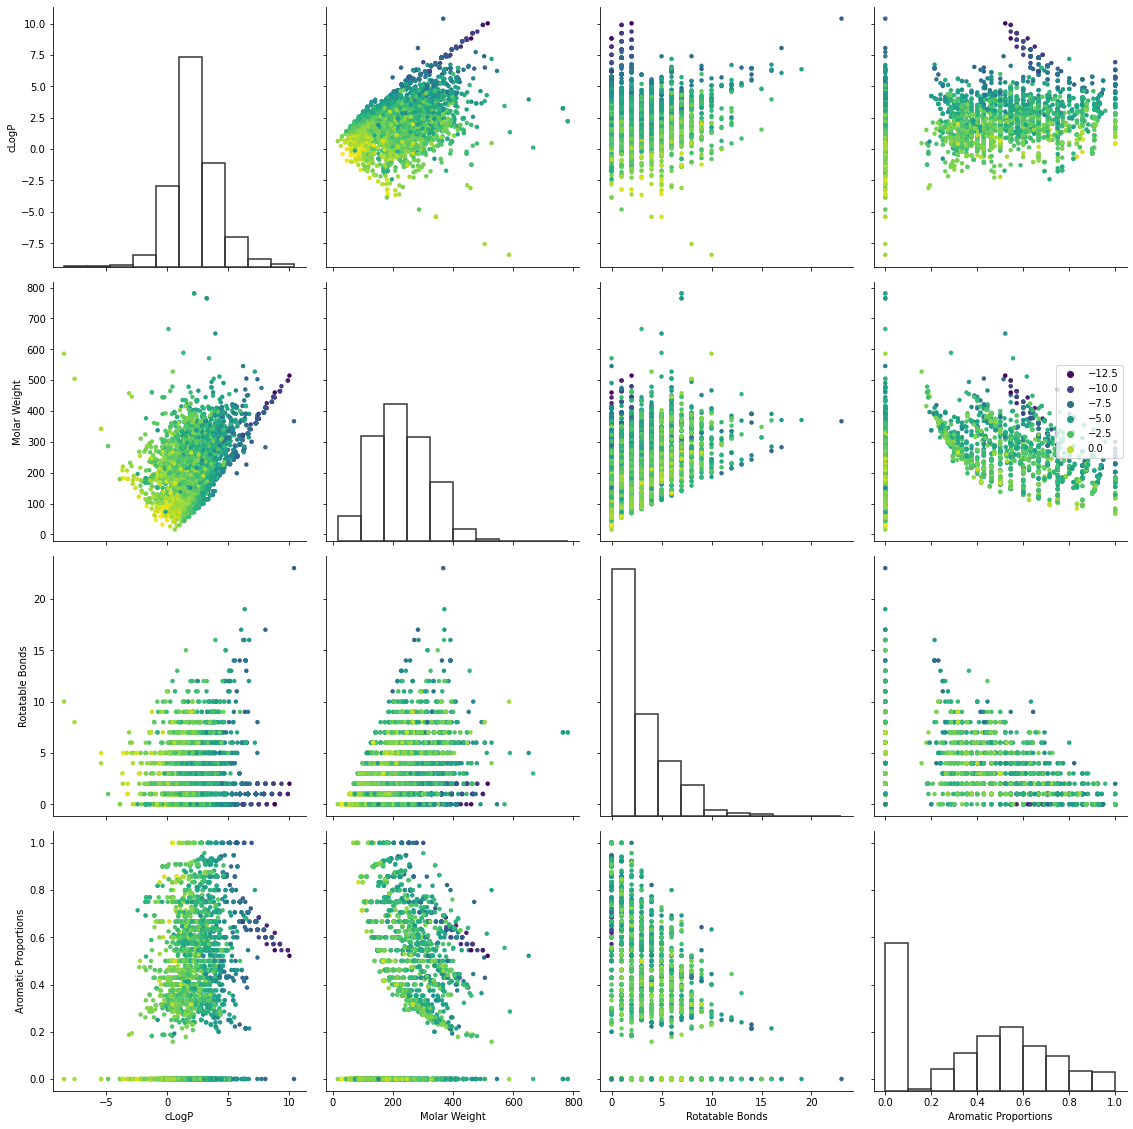

In [8]:
g = sns.PairGrid(X, vars=["cLogP", "Molar Weight", "Rotatable Bonds",'Aromatic Proportions'], height=4)
g.map_diag(sns.histplot, color=".2", fill = None, bins = 10)
g.map_offdiag(sns.scatterplot, hue=df["LogS"], s=20, linewidth=0, palette = 'viridis')
g.axes[1, -1].legend(loc="center left", bbox_to_anchor=(.7, .5));

## Building the Delaney Model 

Our inputs for this model will be all four attributes with the target being solubility. We can see that all of the attributes have low p-values, indicating that they will impact the model with a high level of precision.

In [9]:
y = X['target']
X = X.drop(['target'], axis = 1)

model = OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     2148.
Date:                Mon, 05 Jul 2021   Prob (F-statistic):               0.00
Time:                        18:17:26   Log-Likelihood:                -5611.8
No. Observations:                3664   AIC:                         1.123e+04
Df Residuals:                    3659   BIC:                         1.126e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
intercept                0.1354      0.052      2.620      0.009       0.034       0.237
cLogP                   -0.7203      0.011    -62.780      0.000      -0.743      -0.698
Molar Weight            -0.0062      0.000    -25.940      0.000      -0.007      -0.006
Rotatable Bonds          0.0627      0.008      7.755      0.000       0.047       0.079
Aromatic Proportions    -0.5036      0.067     -7.489      0.000      -0.635      -0.372
==============================================================================
Omnibus:                       62.043   Durbin-Watson:                   1.306
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              103.783
Skew:                          -0.138   Prob(JB):                     2.91e-23
Kurtosis:                       3.777   Cond. No.                         955.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
mean_squared_error(model.predict(X), y, squared=False)

1.1192442980749147

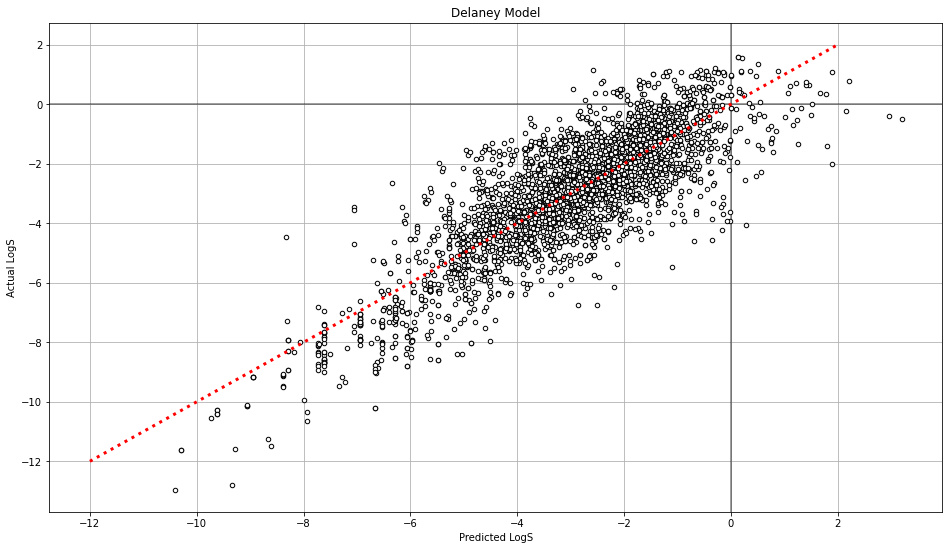

In [11]:
plt.figure(figsize=(16,9))
plt.scatter(model.predict(X), y, color = 'white', zorder = 10, s = 20, edgecolors='black')
plt.grid()
plt.title(f"Delaney Model")
plt.axhline(0, color='black', alpha = 0.5)
plt.axvline(0, color='black', alpha = 0.5)
plt.plot([-12, 2], [-12, 2], color='red', linestyle=':', linewidth=3, zorder= 12)
plt.xlabel("Predicted LogS")
plt.ylabel("Actual LogS")
plt.show()

## Adding more descriptors

The rdkit packages has hundreds of descriptors we can use to increase the accuracy of the linear model. We can iterate through all of the descriptors to build a dataframe containing each attribute that might help us improve the accuracy

In [12]:
X2 = pd.DataFrame()
for i in Descriptors._descList:
    if i[0][:2] != "fr": # Excluding counts of certain chemicals since there are many one-offs 
        print(i[0], end= " - ")
        X2[i[0]] = [getattr(Descriptors, i[0])(Chem.MolFromSmiles(mol)) for mol in df['SMILES']]

MaxEStateIndex - MinEStateIndex - MaxAbsEStateIndex - MinAbsEStateIndex - qed - MolWt - HeavyAtomMolWt - ExactMolWt - NumValenceElectrons - NumRadicalElectrons - MaxPartialCharge - MinPartialCharge - MaxAbsPartialCharge - MinAbsPartialCharge - FpDensityMorgan1 - FpDensityMorgan2 - FpDensityMorgan3 - BCUT2D_MWHI - BCUT2D_MWLOW - BCUT2D_CHGHI - BCUT2D_CHGLO - BCUT2D_LOGPHI - BCUT2D_LOGPLOW - BCUT2D_MRHI - BCUT2D_MRLOW - BalabanJ - BertzCT - Chi0 - Chi0n - Chi0v - Chi1 - Chi1n - Chi1v - Chi2n - Chi2v - Chi3n - Chi3v - Chi4n - Chi4v - HallKierAlpha - Ipc - Kappa1 - Kappa2 - Kappa3 - LabuteASA - PEOE_VSA1 - PEOE_VSA10 - PEOE_VSA11 - PEOE_VSA12 - PEOE_VSA13 - PEOE_VSA14 - PEOE_VSA2 - PEOE_VSA3 - PEOE_VSA4 - PEOE_VSA5 - PEOE_VSA6 - PEOE_VSA7 - PEOE_VSA8 - PEOE_VSA9 - SMR_VSA1 - SMR_VSA10 - SMR_VSA2 - SMR_VSA3 - SMR_VSA4 - SMR_VSA5 - SMR_VSA6 - SMR_VSA7 - SMR_VSA8 - SMR_VSA9 - SlogP_VSA1 - SlogP_VSA10 - SlogP_VSA11 - SlogP_VSA12 - SlogP_VSA2 - SlogP_VSA3 - SlogP_VSA4 - SlogP_VSA5 - SlogP_VSA6 

In [13]:
# Adding aromatic proportions back into the dataframe
X2['Aromatic Proportions'] = df['SMILES'].apply(AromaticProportation)

In [14]:
# Removing any rows with NAs and rows with no variance
X2 = X2.dropna(axis=1)
X2 = X2.loc[:, (X2 != X2.iloc[0]).any()] 
X2['intercept'] = 1

<AxesSubplot:>

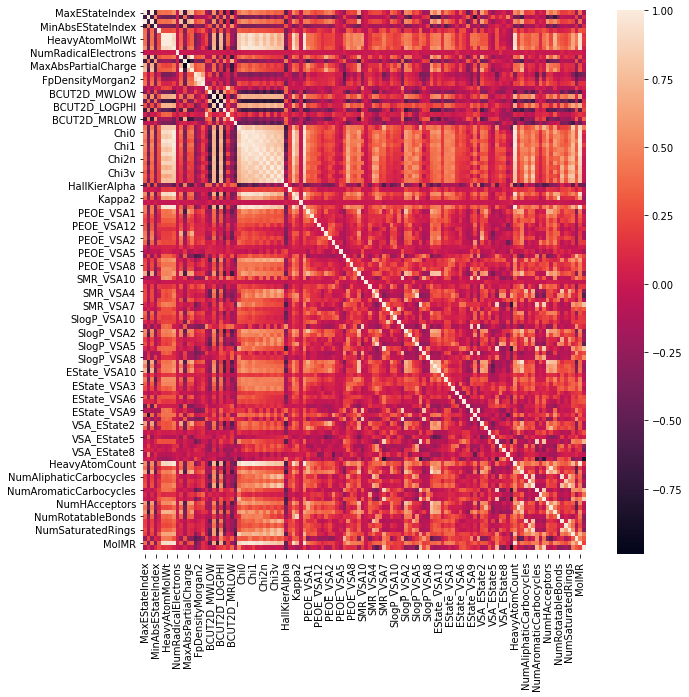

In [15]:
# Heatmap of correlations
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(X2.corr(), ax = ax)

## Comparing the models with training and testing sets

To verify our models aren't overfit or underfit, we can split the dataset we have created into training and testing datasets. This will allow us to cross-validate our models and calculate the accuracy of each of the models

In [16]:
X2 = X2[X2.columns[::-1]]

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y)

In [17]:
model1 = OLS(y_train1,X_train1).fit()
model2 = OLS(y_train2,X_train2).fit()

In [18]:
# Our calculated r_squared
mod2_r2 = r2_score(model2.predict(X_test2), y_test2)
mod2_r2

0.7816085483751296

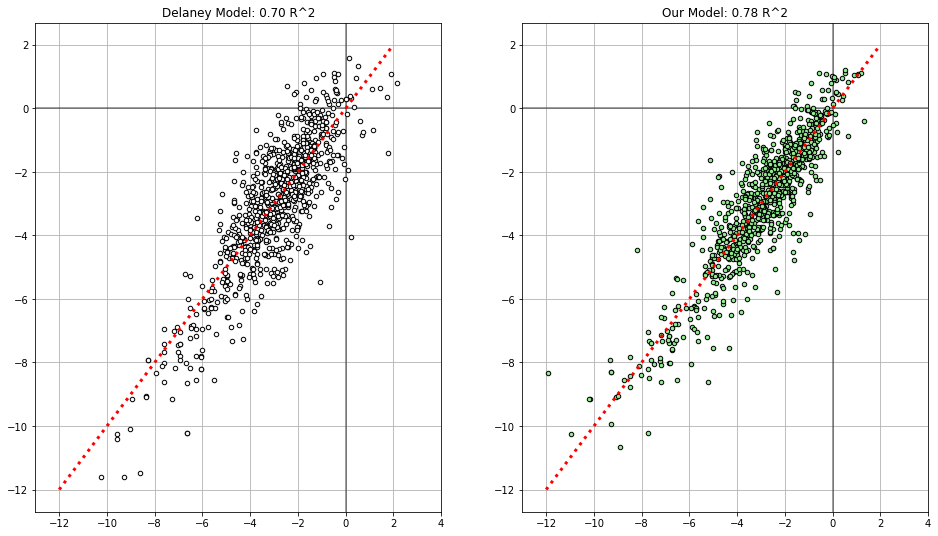

In [19]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(16,9))
ax1.scatter(model1.predict(X_test1), y_test1, color = 'white', zorder = 10, s = 20, edgecolors='black')
ax2.scatter(model2.predict(X_test2), y_test2, color = 'lightgreen', zorder = 10, s = 20, edgecolors='black')
ax1.grid()
ax1.set_title(f"Delaney Model: 0.70 R^2")
ax1.plot([-12, 2], [-12, 2], color='red', linestyle=':', linewidth=3, zorder= 12)
ax1.axhline(0, color='black', alpha = 0.5)
ax1.axvline(0, color='black', alpha = 0.5)
ax1.set_xlim(-13,4)

ax2.grid()
ax2.set_title(f"Our Model: {mod2_r2:.2f} R^2")
ax2.plot([-12, 2], [-12, 2], color='red', linestyle=':', linewidth=3, zorder= 12)
ax2.axhline(0, color='black', alpha = 0.5)
ax2.axvline(0, color='black', alpha = 0.5)
ax2.set_xlim(-13,4)
plt.show()

## Testing the Random Forest Regressor

Random forest creates several decision tree-like models and generates an ensemble based on their results. THis significantly boosts our accuracy.

In [20]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X2, y)

rf_model = RandomForestRegressor()
rf_model.fit(X_train3,y_train3)
mod3_r2 = r2_score(y_test3, rf_model.predict(X_test3))
mod3_r2

0.8382255652604654

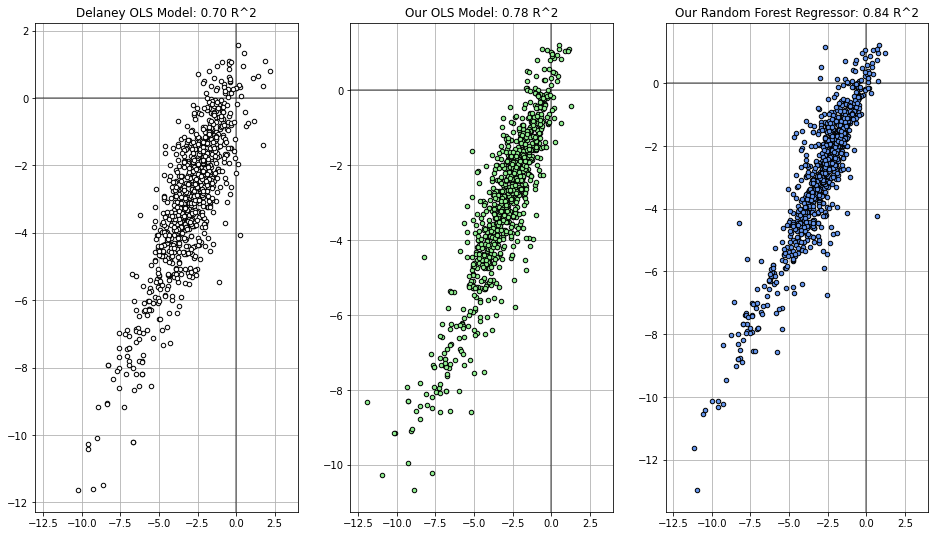

In [21]:
fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(16,9))

ax1.scatter(model1.predict(X_test1), y_test1, color = 'white', zorder = 10, s = 20, edgecolors='black')
ax1.grid()
ax1.set_title(f"Delaney OLS Model: 0.70 R^2")
ax1.axhline(0, color='black', alpha = 0.5)
ax1.axvline(0, color='black', alpha = 0.5)
ax1.set_xlim(-13,4)


ax2.scatter(model2.predict(X_test2), y_test2, color = 'lightgreen', zorder = 10, s = 20, edgecolors='black')
ax2.grid()
ax2.set_title(f"Our OLS Model: {mod2_r2:.2f} R^2")
ax2.axhline(0, color='black', alpha = 0.5)
ax2.axvline(0, color='black', alpha = 0.5)
ax2.set_xlim(-13,4)


ax3.scatter(rf_model.predict(X_test3), y_test3, color = 'cornflowerblue', zorder = 10, s = 20, edgecolors='black')
ax3.grid()
ax3.set_title(f"Our Random Forest Regressor: {mod3_r2:.2f} R^2")
ax3.axhline(0, color='black', alpha = 0.5)
ax3.axvline(0, color='black', alpha = 0.5)
ax3.set_xlim(-13,4)

plt.show()

## Neural Network Regressor
Using a neural network, we can generate results on par with the random forest regressor.

In [22]:
X_scaled = MinMaxScaler().fit_transform(X2)

X_train4, X_test4, y_train4, y_test4 = train_test_split(X_scaled, y)

nn = MLPRegressor(random_state=1, max_iter=500, hidden_layer_sizes=(500,200,100,50), activation='relu')

nn.fit(X_train4,y_train4)

MLPRegressor(hidden_layer_sizes=(500, 200, 100, 50), max_iter=500,
             random_state=1)

In [23]:
mod4_r2 = r2_score(nn.predict(X_test4), y_test4)

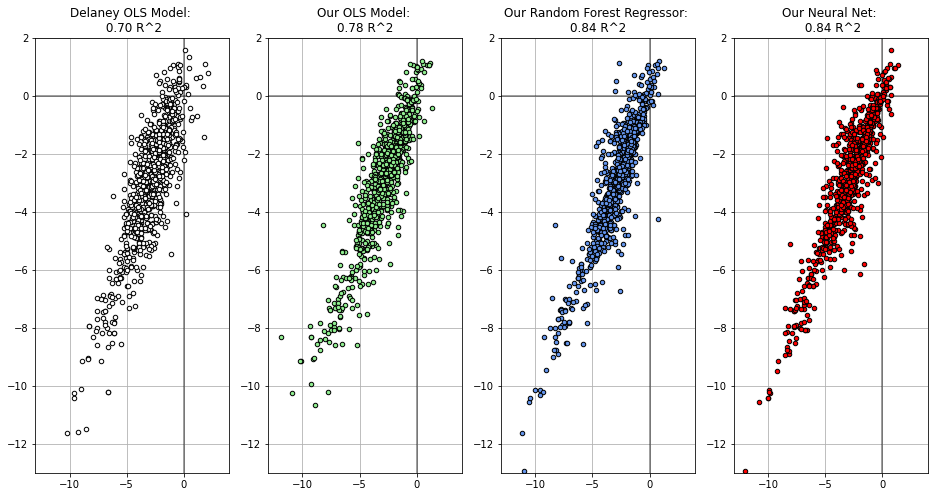

In [24]:
fig, [ax1, ax2, ax3, ax4] = plt.subplots(1,4, figsize=(16,8))

ax1.scatter(model1.predict(X_test1), y_test1, color = 'white', zorder = 10, s = 20, edgecolors='black')
ax1.grid()
ax1.set_title(f"Delaney OLS Model: \n 0.70 R^2")
ax1.axhline(0, color='black', alpha = 0.5)
ax1.axvline(0, color='black', alpha = 0.5)
ax1.set_xlim(-13,4)
ax1.set_ylim(-13,2)

ax2.scatter(model2.predict(X_test2), y_test2, color = 'lightgreen', zorder = 10, s = 20, edgecolors='black')
ax2.grid()
ax2.set_title(f"Our OLS Model: \n{mod2_r2:.2f} R^2")
ax2.axhline(0, color='black', alpha = 0.5)
ax2.axvline(0, color='black', alpha = 0.5)
ax2.set_xlim(-13,4)
ax2.set_ylim(-13,2)

ax3.scatter(rf_model.predict(X_test3), y_test3, color = 'cornflowerblue', zorder = 10, s = 20, edgecolors='black')
ax3.grid()
ax3.set_title(f"Our Random Forest Regressor: \n{mod3_r2:.2f} R^2")
ax3.axhline(0, color='black', alpha = 0.5)
ax3.axvline(0, color='black', alpha = 0.5)
ax3.set_xlim(-13,4)
ax3.set_ylim(-13,2)

ax4.scatter(nn.predict(X_test4), y_test4, color = 'red', zorder = 10, s = 20, edgecolors='black')
ax4.grid()
ax4.set_title(f"Our Neural Net: \n {mod4_r2:.2f} R^2")
ax4.axhline(0, color='black', alpha = 0.5)
ax4.axvline(0, color='black', alpha = 0.5)
ax4.set_xlim(-13,4)
ax4.set_ylim(-13,2)

plt.show()